<a href="https://colab.research.google.com/github/AmiranGozalishvili/Data_Science_course/blob/main/Bicycle_Rental_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import distance

from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
plt.rcParams["figure.figsize"] = (10, 8)

In [ ]:
data = pd.read_csv('/content/hour.csv')

In [ ]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [ ]:
data.season.value_counts()

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64

In [ ]:
data.weathersit.value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

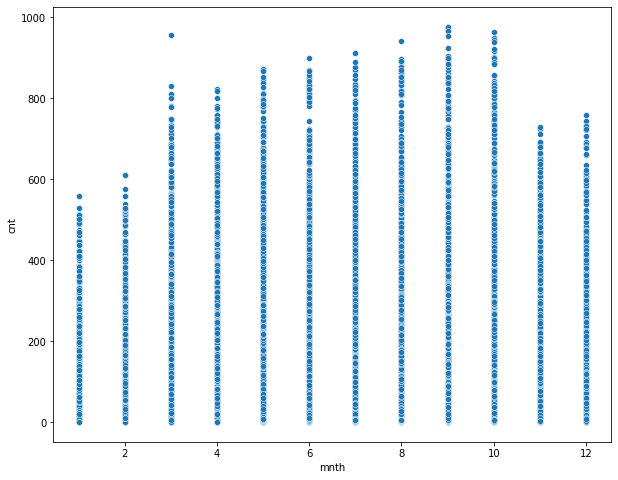

In [ ]:
sns.scatterplot(data=data, x="mnth", y="cnt")

<AxesSubplot:>

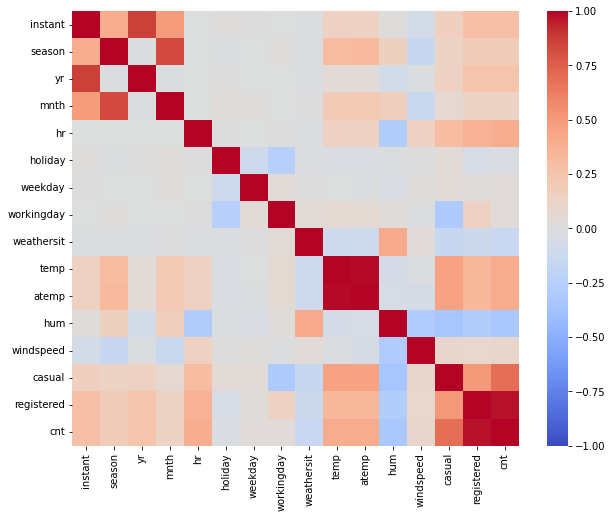

In [ ]:
sns.heatmap(data.corr(), cmap="coolwarm", vmin=-1, vmax=1)

In [ ]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

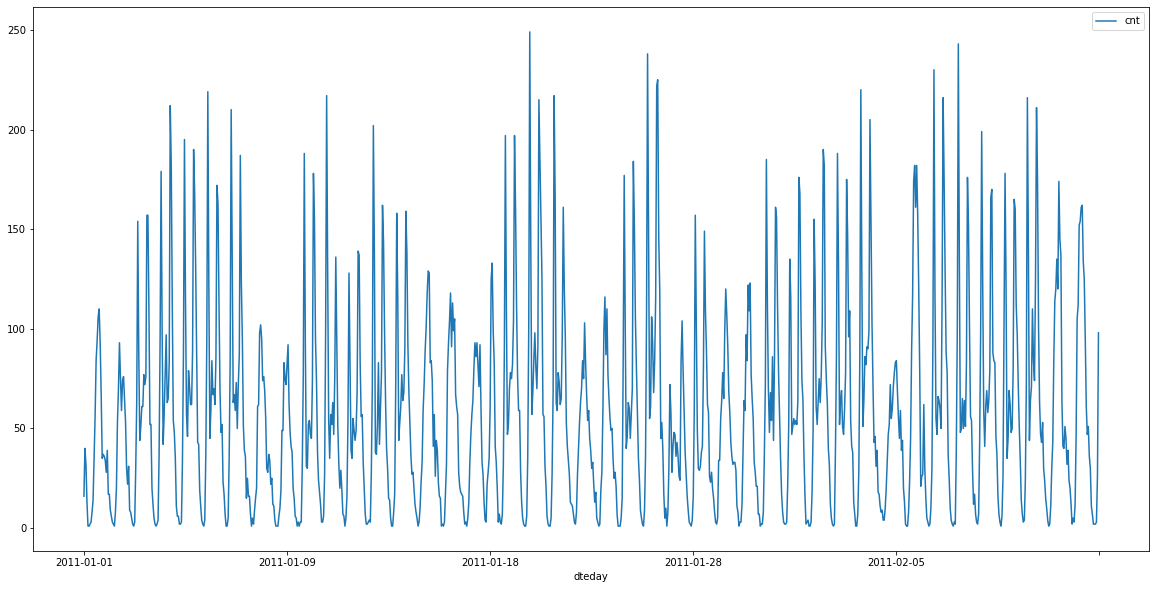

In [ ]:
data[:1000].plot(x="dteday", y=['cnt'],
        kind="line", figsize=(20, 10))
mp.show()

In [ ]:
data['dteday'] = pd.to_datetime(data['dteday'],format='%Y-%m-%d')

In [ ]:
continuous = ['temp', 'hum', 'windspeed','casual', 'registered', 'cnt']

categorical=['yr', 'hr', 'weekday','workingday', 'weathersit']

In [ ]:
def one_hot_encode(data):
  ohe = OneHotEncoder(sparse_output=False)
  temp = pd.DataFrame(data=ohe.fit_transform(data[categorical]), columns=ohe.get_feature_names_out(categorical))
  df_onehot = data.merge(temp, left_index=True, right_index=True)

  return df_onehot


In [ ]:
df_onehot = one_hot_encode(data)

In [ ]:
df_onehot.set_index('dteday', inplace=True)

In [ ]:
df = df_onehot.resample('W').sum()

In [ ]:
df

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-02,1128,47,0,47,547,0,144,0,83,16.62,...,0.0,0.0,0.0,24.0,47.0,0.0,18.0,22.0,7.0,0.0
2011-01-09,20817,162,0,162,1915,0,488,114,204,30.64,...,23.0,23.0,23.0,24.0,48.0,114.0,125.0,32.0,5.0,0.0
2011-01-16,47433,163,0,163,1914,0,489,115,220,29.96,...,22.0,24.0,23.0,24.0,48.0,115.0,112.0,45.0,6.0,0.0
2011-01-23,68697,153,0,153,1854,24,471,83,238,27.66,...,23.0,24.0,24.0,23.0,70.0,83.0,78.0,65.0,10.0,0.0
2011-01-30,82705,139,0,139,1662,0,402,93,226,26.60,...,16.0,8.0,23.0,23.0,46.0,93.0,73.0,46.0,19.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-09,2817276,672,168,2016,1932,0,504,120,268,65.02,...,24.0,24.0,24.0,24.0,48.0,120.0,83.0,70.0,15.0,0.0
2012-12-16,2845500,672,168,2016,1932,0,504,120,266,56.42,...,24.0,24.0,24.0,24.0,48.0,120.0,79.0,80.0,9.0,0.0
2012-12-23,2873724,456,168,2016,1932,0,504,120,248,55.32,...,24.0,24.0,24.0,24.0,48.0,120.0,101.0,54.0,13.0,0.0


In [ ]:
df.columns

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'yr_0', 'yr_1', 'hr_0', 'hr_1', 'hr_2',
       'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10',
       'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18',
       'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'workingday_0', 'workingday_1', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weathersit_4'],
      dtype='object')

In [ ]:
df = df.drop(['season', 'holiday','atemp', 'casual', 'registered', 'yr', 'hr', 'weekday','workingday', 'weathersit'], axis=1)

In [ ]:
df['mean'] = df['cnt'].expanding(1).mean()

In [ ]:
df

,instant,mnth,temp,hum,windspeed,cnt,yr_0,yr_1,hr_0,hr_1,...,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mean
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-02,1128,47,16.62,35.35,9.5671,1786,47.0,0.0,2.0,2.0,...,0.0,0.0,24.0,47.0,0.0,18.0,22.0,7.0,0.0,1786.000000
2011-01-09,20817,162,30.64,79.92,34.4791,9408,162.0,0.0,7.0,7.0,...,23.0,23.0,24.0,48.0,114.0,125.0,32.0,5.0,0.0,5597.000000
2011-01-16,47433,163,29.96,87.12,33.1952,9025,163.0,0.0,7.0,7.0,...,24.0,23.0,24.0,48.0,115.0,112.0,45.0,6.0,0.0,6739.666667
2011-01-23,68697,153,27.66,83.43,34.0156,8770,153.0,0.0,6.0,6.0,...,24.0,24.0,23.0,70.0,83.0,78.0,65.0,10.0,0.0,7247.250000
2011-01-30,82705,139,26.60,94.64,20.1201,7699,139.0,0.0,6.0,6.0,...,8.0,23.0,23.0,46.0,93.0,73.0,46.0,19.0,1.0,7337.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-09,2817276,2016,65.02,121.82,27.4939,37762,0.0,168.0,7.0,7.0,...,24.0,24.0,24.0,48.0,120.0,83.0,70.0,15.0,0.0,31534.980392
2012-12-16,2845500,2016,56.42,112.27,27.8816,35966,0.0,168.0,7.0,7.0,...,24.0,24.0,24.0,48.0,120.0,79.0,80.0,9.0,0.0,31578.000000
2012-12-23,2873724,2016,55.32,105.12,37.2247,26696,0.0,168.0,7.0,7.0,...,24.0,24.0,24.0,48.0,120.0,101.0,54.0,13.0,0.0,31531.057692


In [ ]:
endogenous = ['instant', 'cnt', 'yr_0', 'yr_1', 'hr_0', 'hr_1', 'hr_2',
       'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10',
       'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18',
       'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'workingday_0', 'workingday_1']
exogenous = ['temp', 'hum', 'windspeed', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weathersit_4']

In [ ]:
X_train = df[endogenous].drop('cnt', axis=1)[:100].fillna(df['mean'].mode())
X_test = df[endogenous].drop('cnt', axis=1)[100:].fillna(df['mean'].mode())
y_train = df['cnt'][:100].fillna(df['mean'].mode())
y_test = df['cnt'][100:].fillna(df['mean'].mode())

In [ ]:
linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)
y_pred

array([ 43200.9232895 ,  48108.94221318,  48309.04000573,  48509.13779829,
        29357.20345512, 189377.19522213])

In [ ]:
mean_absolute_error(y_test, y_pred)

42975.406997325576

# EDA

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

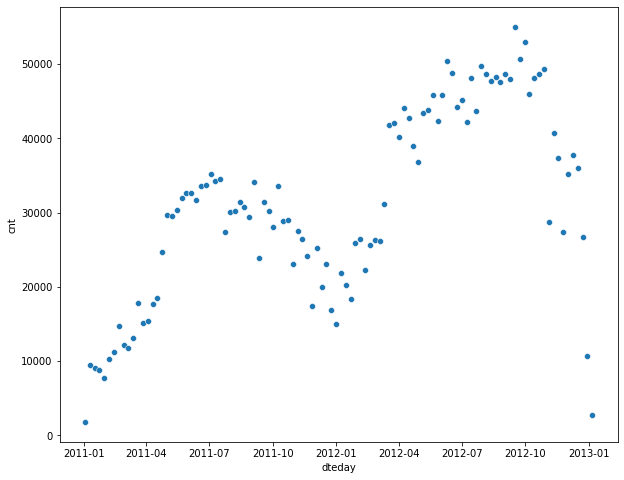

In [ ]:
sns.scatterplot(data=df, x=df.index, y='cnt')

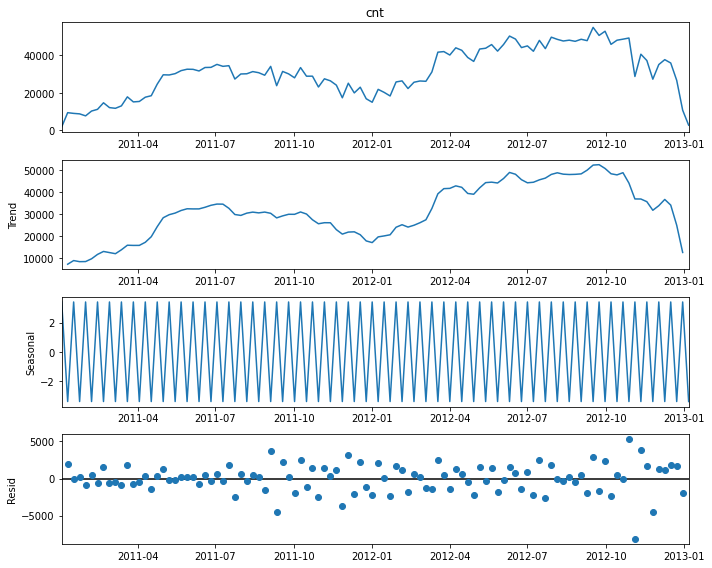

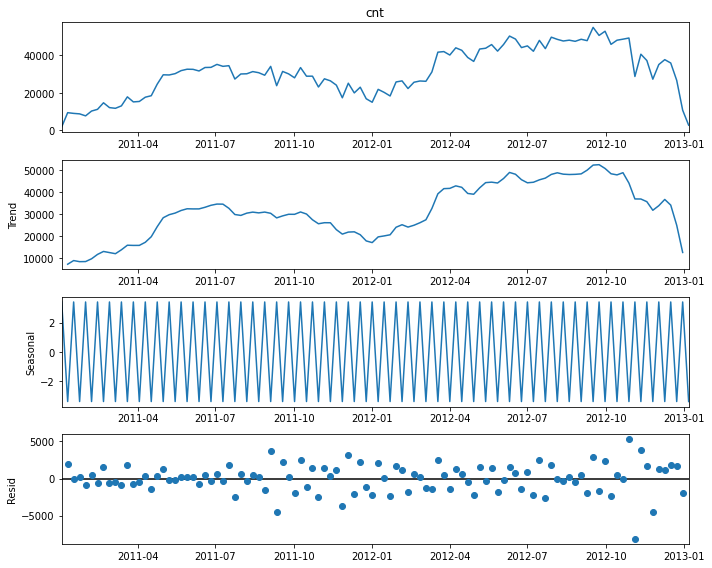

In [ ]:
result=seasonal_decompose(df['cnt'], model='additive', period=2)
result.plot()

In [ ]:
y = df['cnt']

alpha = 0.05
print(f"alpha = {alpha}\n")

# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -1.479
p-value: 0.5439
The process is non-stationary.


In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(y, regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.")
else:
    print("The process is stationary.")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.9813
p-value = 0.01
The process is non-stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


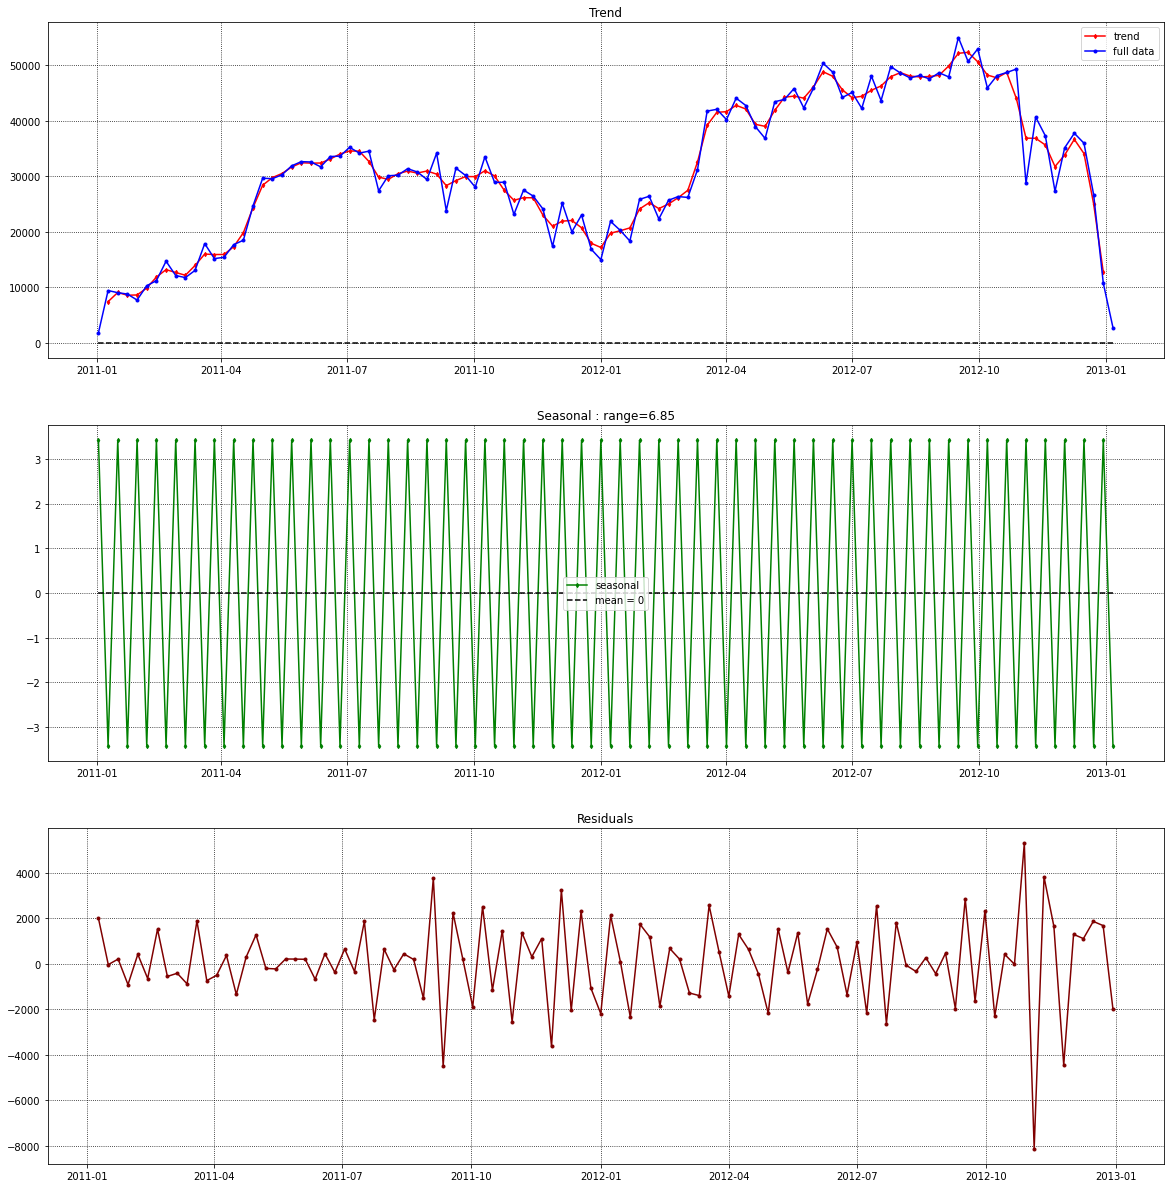

In [ ]:
decomposition = seasonal_decompose(y, model='aditive', period=2)



plt.subplots(3, 1, figsize=(20, 21))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend,
         '-d', color='red', markersize=3, label='trend')
plt.plot(df['cnt'], '-bo', markersize=3, label='full data')
# plt.plot(decomposition.trend.index[0], 0)
plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")


plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal,
         '-gd', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]],
         decomposition.seasonal.mean()*np.array([1, 1]), '--k',
         label=f"mean = {decomposition.seasonal.mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

# Analysis of decomposition residuals

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


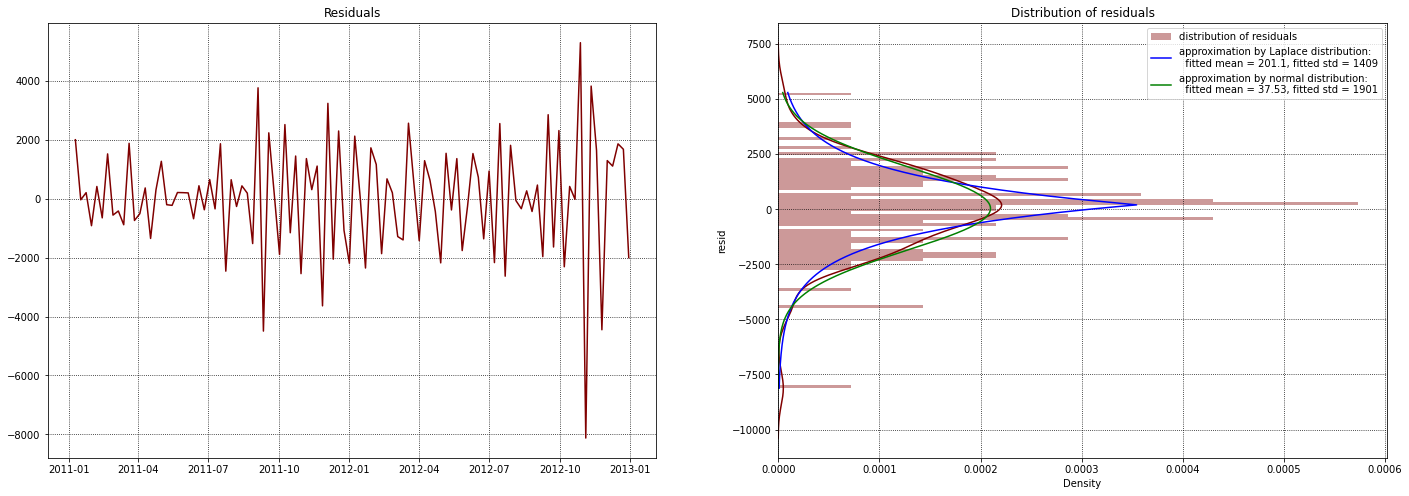

In [ ]:
resid = decomposition.resid
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")



x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())
# print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b',
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g',
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
# plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

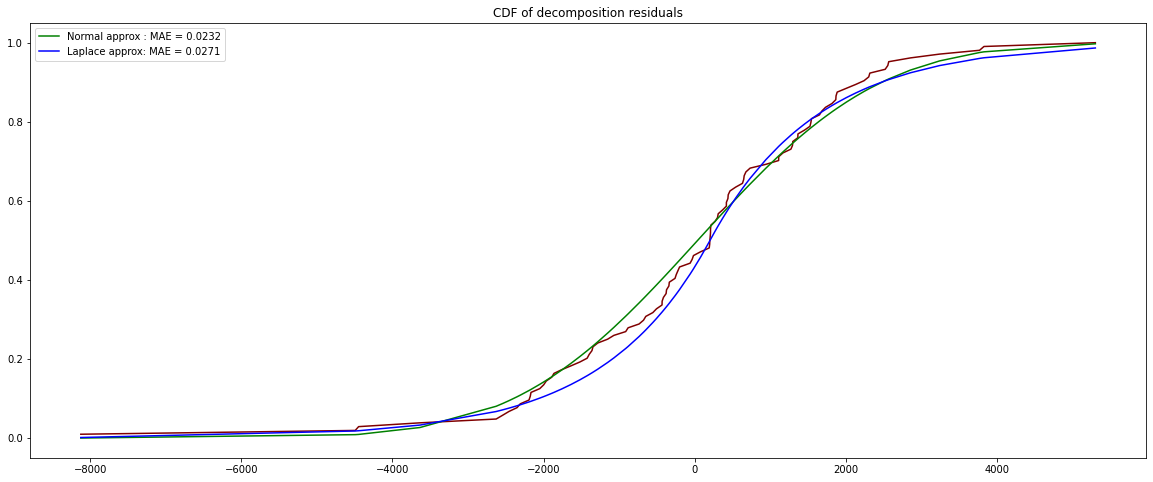

MAE_Gaussian/MAE_Laplace = 0.856.


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g',
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b',
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(f"MAE_Gaussian/MAE_Laplace = {mae_norm/mae_laplace:.3g}.")

# Autocorrelation of residuals

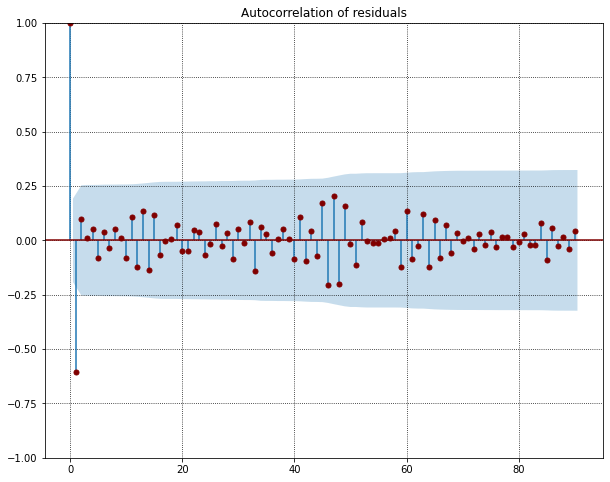

In [ ]:
lags = 90

plot_acf(resid.dropna(), lags=lags, color='maroon',
         title='Autocorrelation of residuals');
plt.grid(linestyle=':', color='k')
plt.show()

# Test for trend stationarity

In [ ]:
trend = decomposition.trend.dropna()

In [ ]:
alpha = 0.05


print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(trend.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.\n")
else:
    print("The process is non-stationary.\n")

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -2.19
p-value: 0.2097
The process is non-stationary.



In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(trend.dropna(), regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.\n")
else:
    print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 1.059
p-value = 0.01
The process is non-stationary.



/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


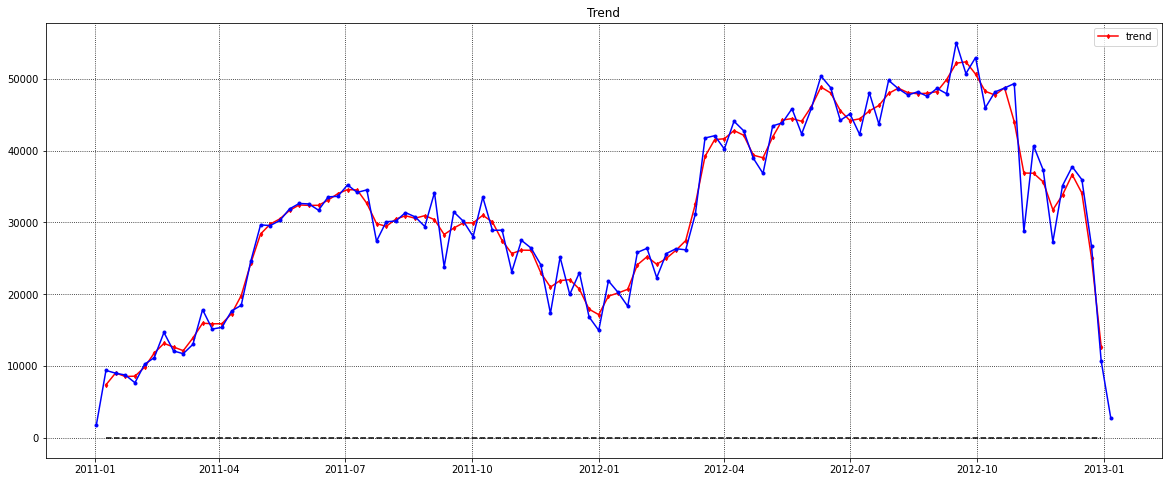

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend, '-d', color='red', markersize=3, label='trend')
plt.plot(df['cnt'], '-bo', markersize=3)
plt.plot([trend.index[0], trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")
plt.show()

Let us differentiate trend to get rid of non-stationarity and perform analysis of 1st derivative of trend.

Text(0.5, 1.0, '1st derivative of trend')

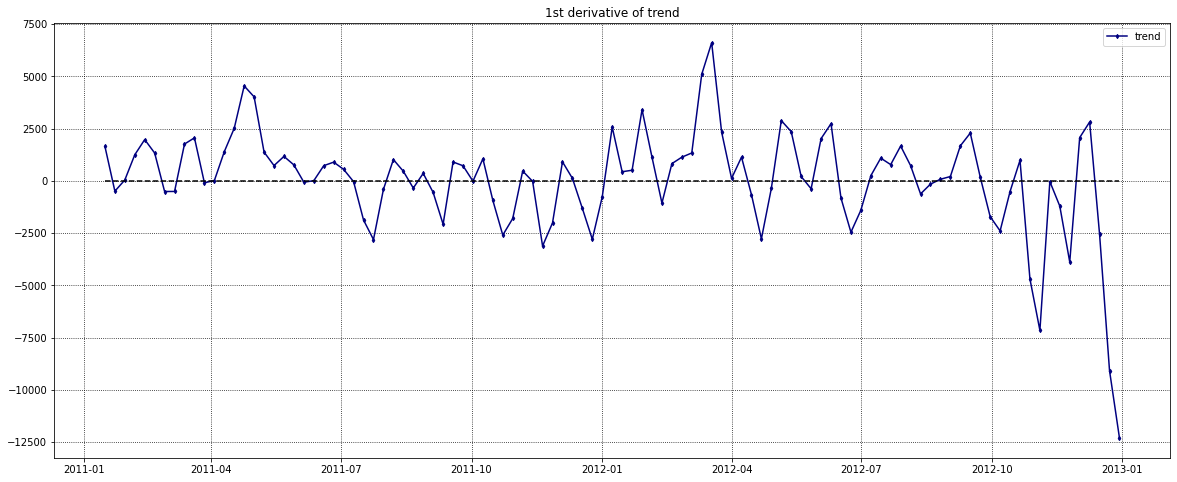

In [ ]:
trend_diff = trend.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([trend_diff.index[0], trend_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("1st derivative of trend")

In [ ]:
alpha = 0.05


print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(trend_diff, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -0.1537
p-value: 0.9438
The process is non-stationary.


In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(trend_diff, regression='c')
print(f"KPSS Statistic = {kpsstest[0]:.4g}")
print(f"p-value = {kpsstest[1]:.4g}")
if kpsstest[1] < alpha:
    print("The process is non-stationary.")
else:
    print("The process is stationary.")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.5227
p-value = 0.03656
The process is non-stationary.


# First difference (derivative)

In [ ]:
y = df['cnt'].diff().dropna()
y

dteday
2011-01-09     7622.0
2011-01-16     -383.0
2011-01-23     -255.0
2011-01-30    -1071.0
2011-02-06     2574.0
               ...   
2012-12-09     2625.0
2012-12-16    -1796.0
2012-12-23    -9270.0
2012-12-30   -15976.0
2013-01-06    -7991.0
Freq: W-SUN, Name: cnt, Length: 105, dtype: float64

In [ ]:
alpha = 0.05
print(f"alpha = {alpha}\n")

# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(y, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
    print("The process is stationary.\n")
else:
    print("The process is non-stationary.\n")

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -12.363945595492233
p-value: 5.467481680306786e-23
The process is stationary.



In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(y, regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
    print("The process is non-stationary.\n")
else:
    print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.512255431025763
p-value = 0.038906434453656984
The process is non-stationary.



# Time Series Decomposition

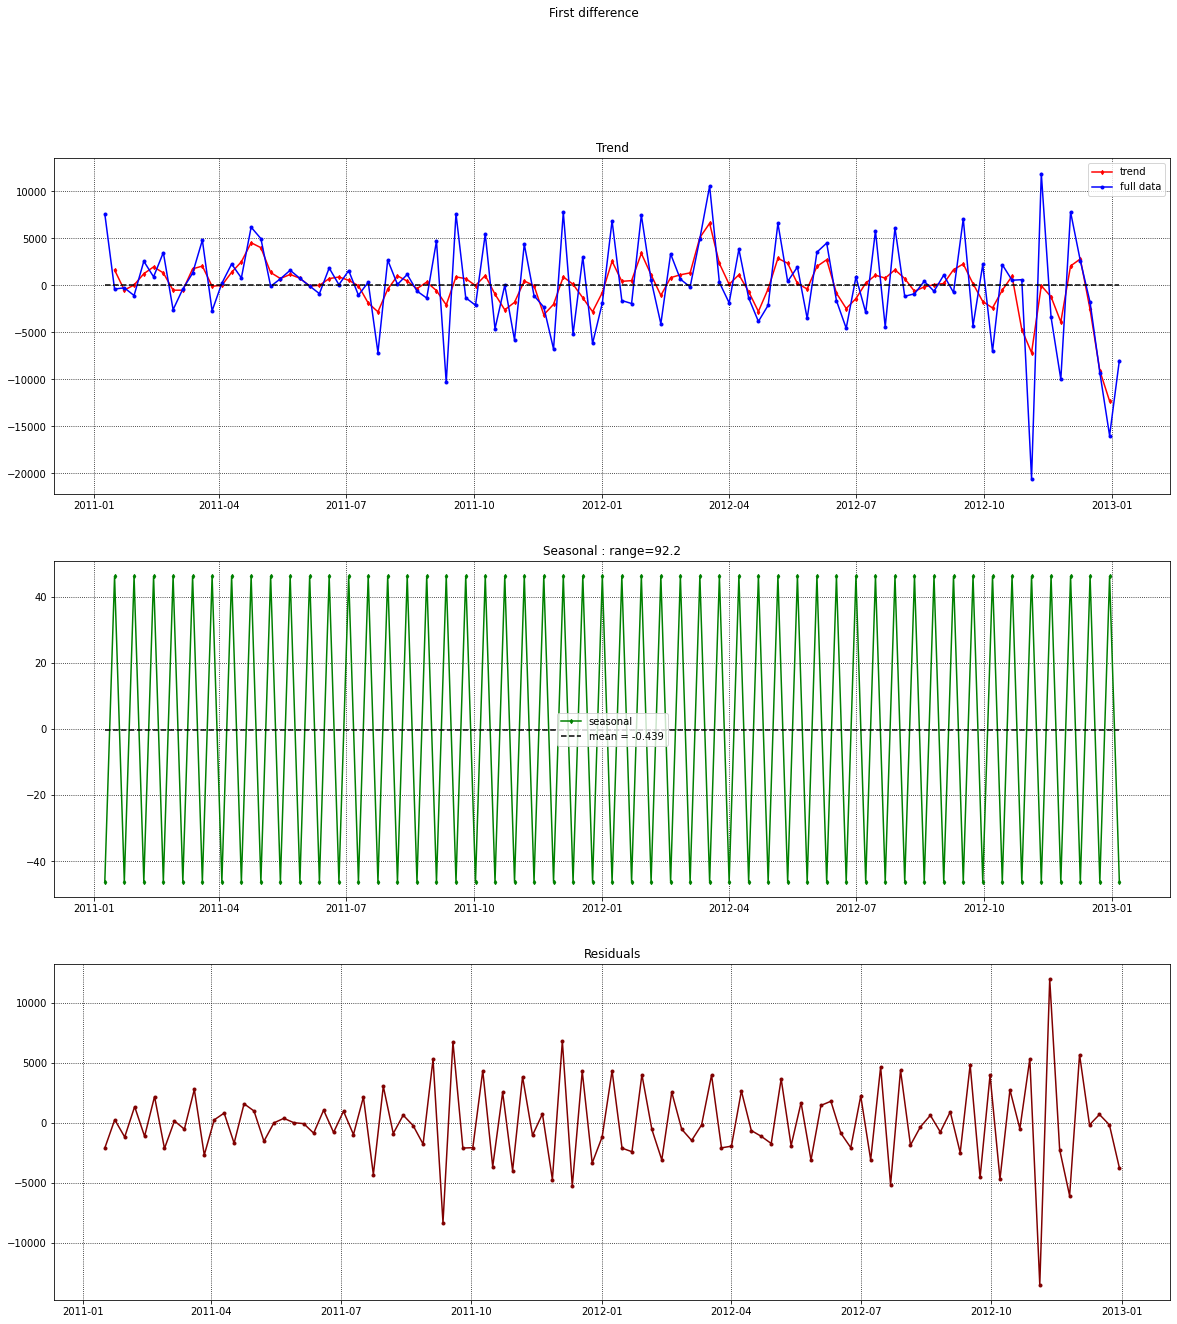

In [ ]:
decomposition = seasonal_decompose(y, model='additive', period=2)



plt.subplots(3, 1, figsize=(20, 21))
plt.suptitle("First difference")

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend,
         '-d', color='red', markersize=3, label='trend')
plt.plot(y, '-bo', markersize=3, label='full data')
# plt.plot(decomposition.trend.index[0], 0)
plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")


plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal,
         '-gd', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]],
         decomposition.seasonal.mean()*np.array([1, 1]), '--k',
         label=f"mean = {decomposition.seasonal.mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

Analysis of decomposition residuals

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


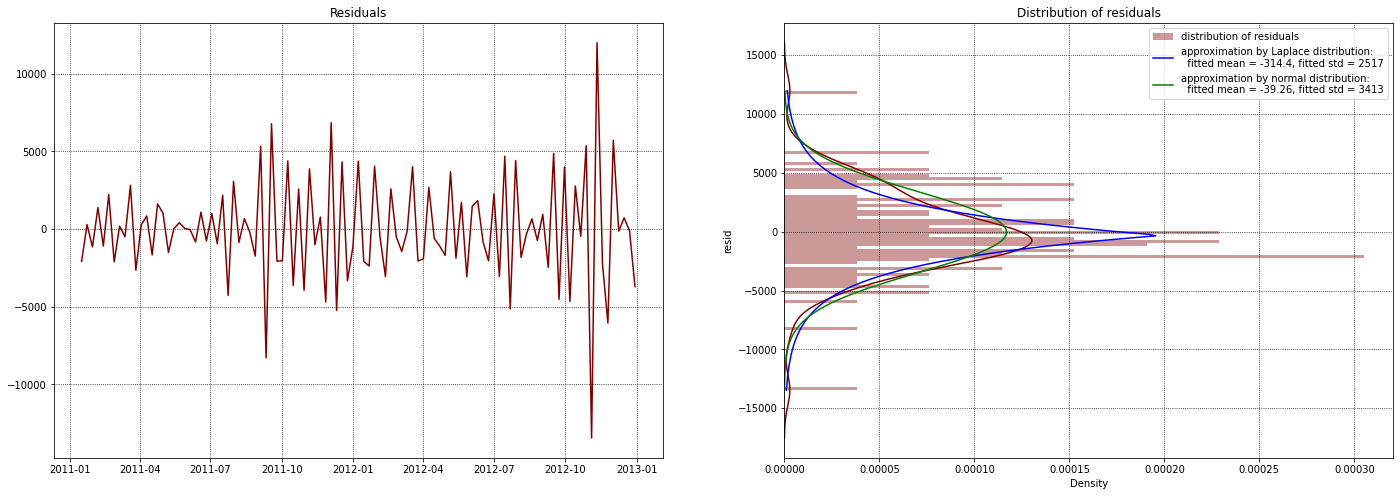

In [ ]:
resid = decomposition.resid
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")



x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())

y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b',
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g',
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
# plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

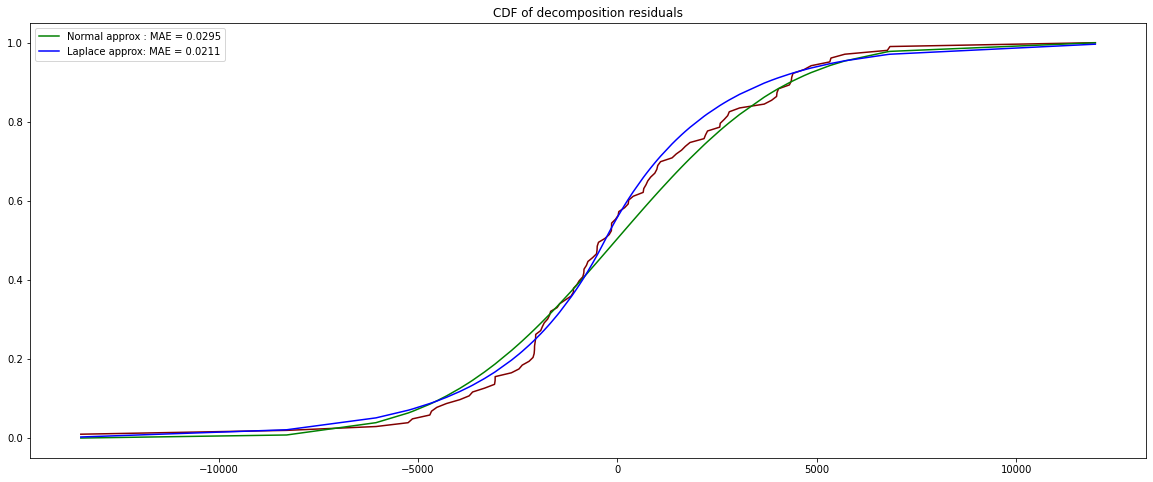

MAE_Gaussian/MAE_Laplace = 1.39.


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g',
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b',
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(f"MAE_Gaussian/MAE_Laplace = {mae_norm/mae_laplace:.3g}.")

# Correlation Analysis (of first difference)

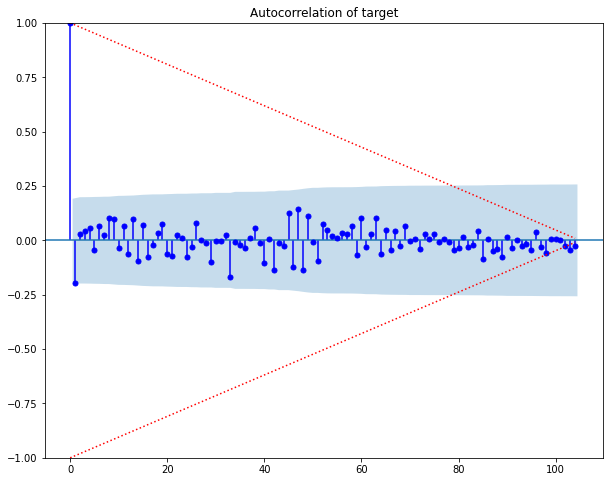

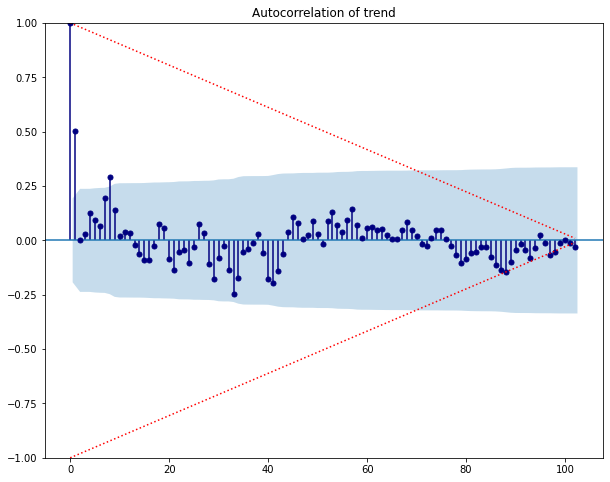

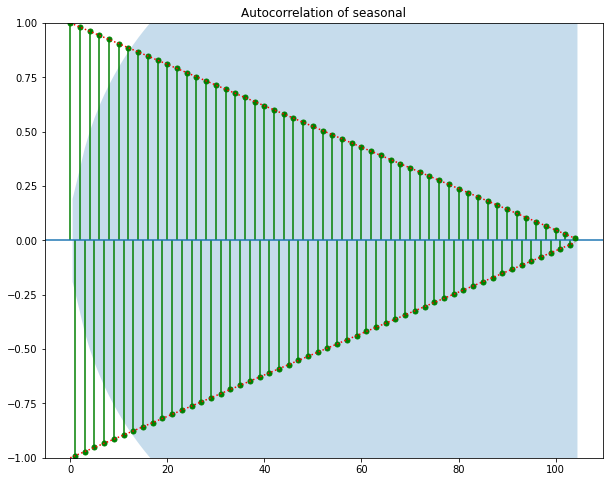

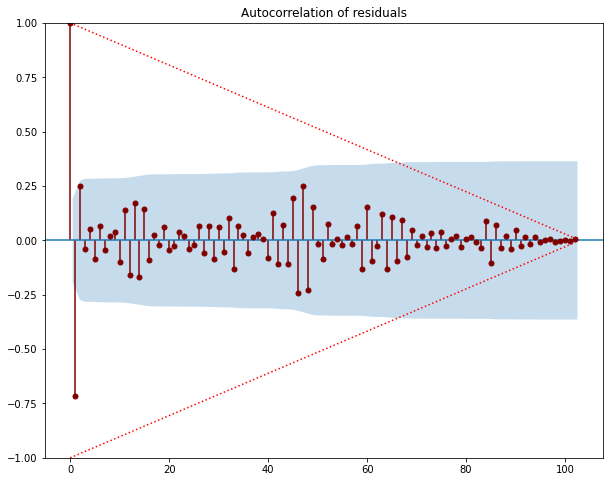

In [ ]:
N = len(y)
k = np.arange(0, N)
plot_acf(y,
         lags=N-1,
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b',
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')

trend = decomposition.trend.dropna()
N = len(trend)
k = np.arange(0, N)
plot_acf(trend,
         lags=N-1,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
k = np.arange(0, N)
plot_acf(seasonal,
         lags=N-1,
         vlines_kwargs={'color' : 'g'},
         markerfacecolor='g', markeredgecolor='g',
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
k = np.arange(0, N)
plot_acf(resid.dropna(),
         lags=N-1,
         vlines_kwargs={'color' : 'maroon'},
         markerfacecolor='maroon', markeredgecolor='maroon',
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

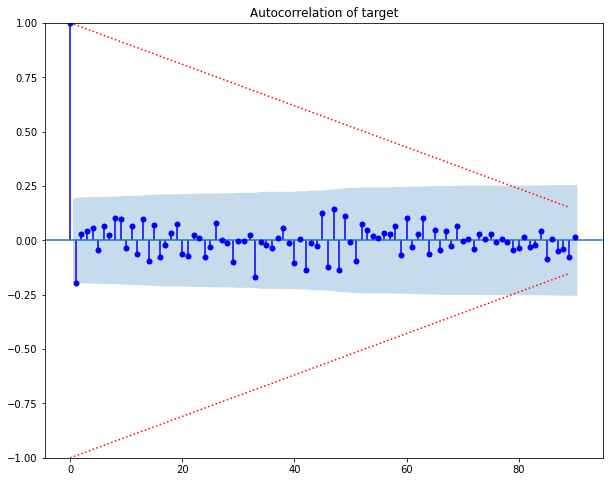

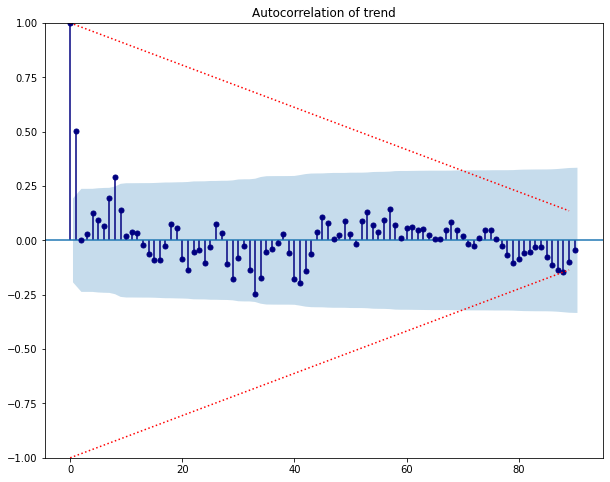

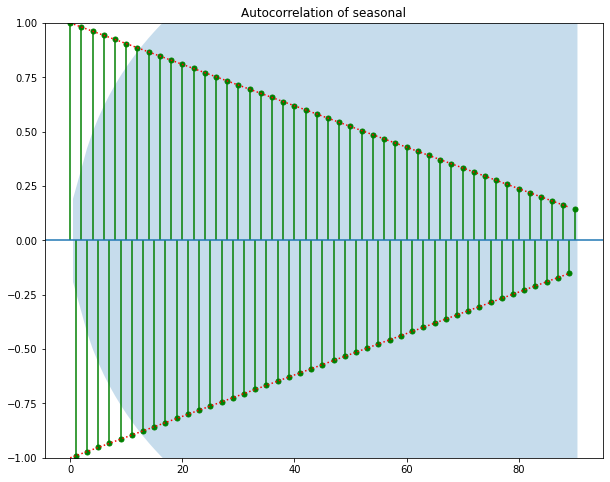

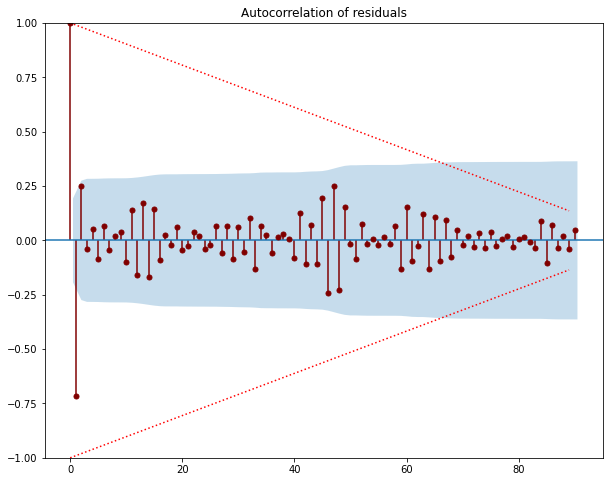

In [ ]:
lags = 90

N = len(y)
k = np.arange(0, lags)
plot_acf(y,
         lags=lags,
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b',
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend)
plot_acf(trend,
         lags=lags,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
plot_acf(seasonal,
         lags=lags,
         vlines_kwargs={'color' : 'g'},
         markerfacecolor='g', markeredgecolor='g',
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
plot_acf(resid.dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'maroon'},
         markerfacecolor='maroon', markeredgecolor='maroon',
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


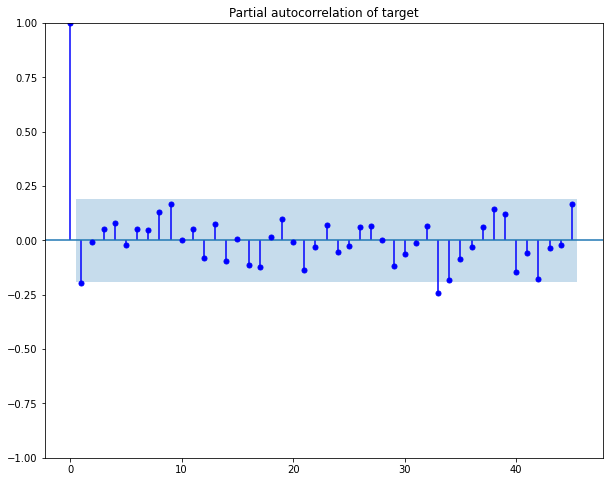

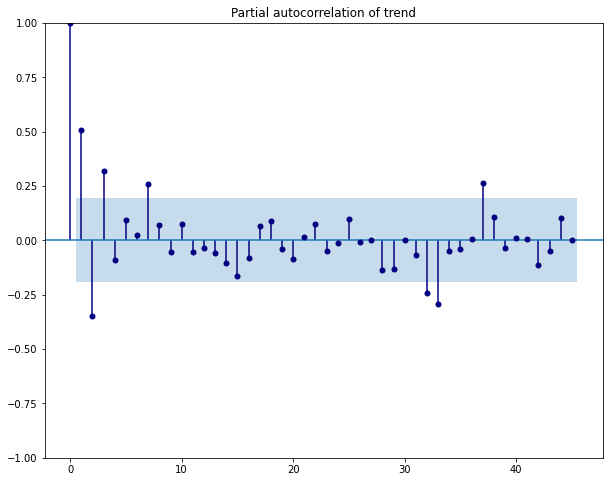

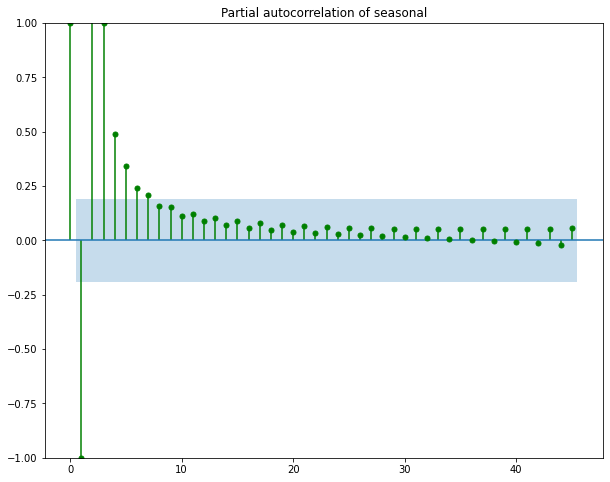

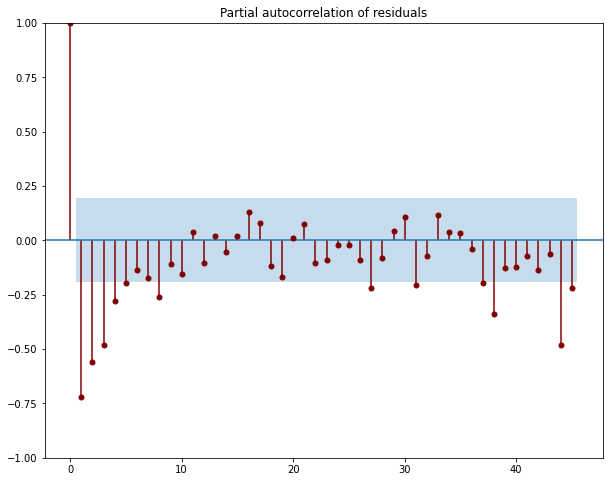

In [ ]:
lags = 45

plot_pacf(y,
         lags=lags,
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b',
         title='Partial autocorrelation of target');


plot_pacf(trend.dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Partial autocorrelation of trend');


seasonal = decomposition.seasonal
plot_pacf(seasonal,
         lags=lags,
         vlines_kwargs={'color' : 'g'},
         markerfacecolor='g', markeredgecolor='g',
         title='Partial autocorrelation of seasonal');


plot_pacf(resid.dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'maroon'},
         markerfacecolor='maroon', markeredgecolor='maroon',
         title='Partial autocorrelation of residuals');


plt.show()

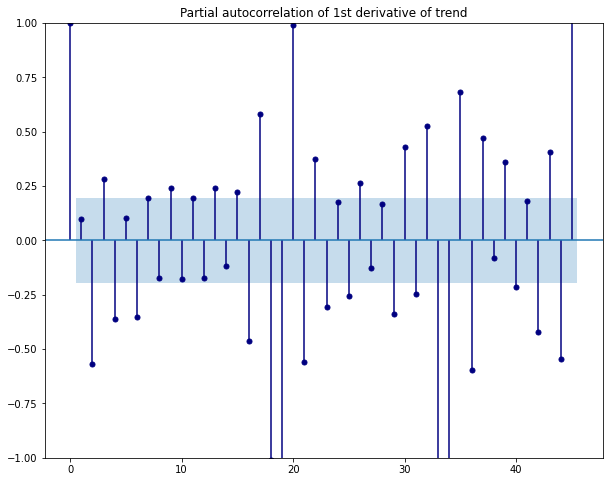

In [ ]:
plot_pacf(trend.dropna().diff().dropna(),
         lags=lags,
         vlines_kwargs={'color' : 'navy'},
         markerfacecolor='navy', markeredgecolor='navy',
         title='Partial autocorrelation of 1st derivative of trend');

In [ ]:
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data splitting

In [ ]:
new_df = pd.DataFrame(df['cnt'])

In [ ]:
new_df.reset_index()

,dteday,cnt
0,2011-01-02,1786
1,2011-01-09,9408
2,2011-01-16,9025
3,2011-01-23,8770
4,2011-01-30,7699
...,...,...
101,2012-12-09,37762
102,2012-12-16,35966
103,2012-12-23,26696
104,2012-12-30,10720


In [ ]:
N_test = 4
print(f"we have {len(new_df)} points totally and last {N_test} test points amongst them.")

train_ind = np.arange(len(new_df)-N_test)
test_ind = np.arange(len(new_df)-N_test, len(new_df))

train = new_df.iloc[train_ind, :]
test = new_df.iloc[test_ind, :]

we have 106 points totally and last 4 test points amongst them.


## Forecasting

### Naive approach

Let us obtain seasonal component as determenistic function and fit trend with polynomial (p=2) regression.

In [ ]:
decomposition = seasonal_decompose(train, model='additive', period=2)

trend = decomposition.trend
seasonal = decomposition.seasonal

In [ ]:
def seasonal_component(ind, period=2):
    seasonal_unit = seasonal[:period].values
    ind_norm = ind % period

    return seasonal_unit[ind_norm]

[-9.61708900e-01  4.27216300e+02  1.34372264e+04]


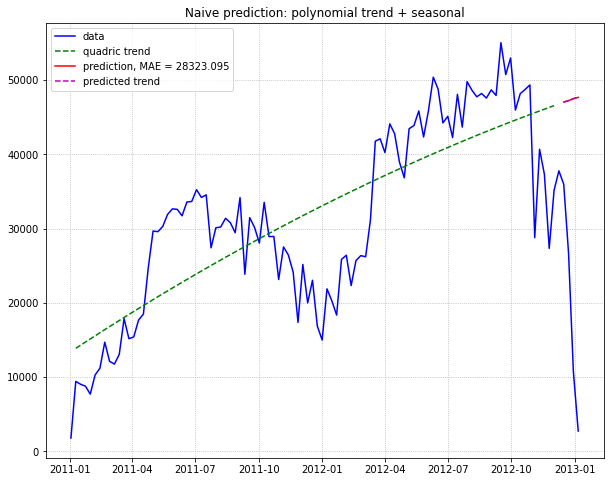

In [ ]:
X_train = trend.reset_index(drop=True).dropna()
X_train_ind = np.array(X_train.index)
y_train = X_train.values

poly_coeff = np.polyfit(X_train_ind, y_train, 2)
print(poly_coeff)
trend_pred = np.polyval(poly_coeff, test_ind)
pred = trend_pred + seasonal_component(test_ind)


trend_pred_train = np.polyval(poly_coeff, X_train_ind)

mae_naive = mean_absolute_error(test, pred)

plt.plot(new_df.index, new_df, '-b', label="data")
plt.plot(trend[X_train.index].index, trend_pred_train, '--g', label="quadric trend")

plt.plot(test.index, pred, '-r', label=f"prediction, MAE = {mae_naive:0.3f}")
plt.plot(test.index, trend_pred, '--m', label=f"predicted trend")
plt.grid(linestyle=':')
plt.legend()
plt.title("Naive prediction: polynomial trend + seasonal")
plt.show()

### ARIMA

In [ ]:
p, d, q = 12, 1, 12

arima_model = ARIMA(train, order=(p, d, q)).fit()
print()
print(f"ARIMA model ({p}, {d}, {q}):")
print(arima_model.params)

prediction_arima_train = arima_model.predict(train.index[0], train.index[-1])
prediction_arima_test = arima_model.predict(test_ind[0], test_ind[-1])

mae_arima = mean_absolute_error(y_true=test, y_pred=prediction_arima_test)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA model (12, 1, 12):
ar.L1     2.418845e-01
ar.L2     1.659718e-02
ar.L3     8.451771e-02
ar.L4     3.318682e-01
ar.L5    -3.348472e-01
ar.L6    -5.197669e-03
ar.L7    -2.614681e-01
ar.L8     2.719074e-01
ar.L9     3.418002e-01
ar.L10   -1.857952e-01
ar.L11    4.217362e-01
ar.L12   -4.491626e-01
ma.L1    -6.438693e-01
ma.L2     1.533050e-01
ma.L3     5.784275e-02
ma.L4    -3.041894e-01
ma.L5     3.672343e-01
ma.L6     2.529607e-02
ma.L7     3.556510e-01
ma.L8    -5.027237e-01
ma.L9    -1.027929e-01
ma.L10    4.509243e-01
ma.L11   -7.299183e-01
ma.L12    4.698871e-01
sigma2    1.729949e+07
dtype: float64


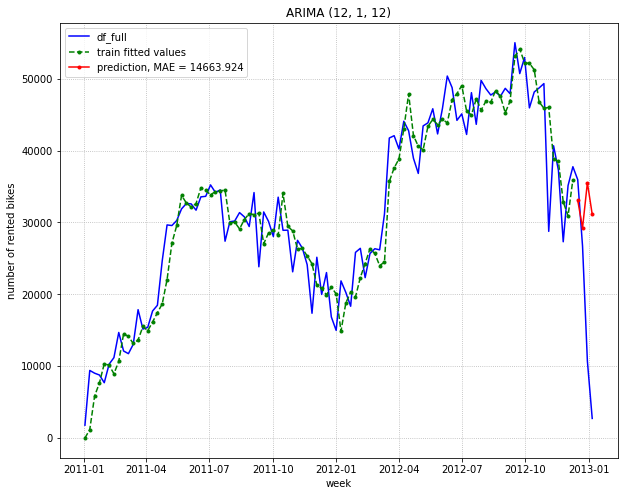

In [ ]:
plt.plot(new_df.index, new_df, '-b', label="df_full")
plt.plot(arima_model.fittedvalues, '--og', markersize=3,
         label="train fitted values")
plt.plot(test.index, prediction_arima_test, '-or', markersize=3,
         label=f"prediction, MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':')
plt.legend()
plt.xlabel("week")
plt.ylabel("number of rented bikes")
plt.title(f"ARIMA {(p, d, q)}")
plt.show(True)

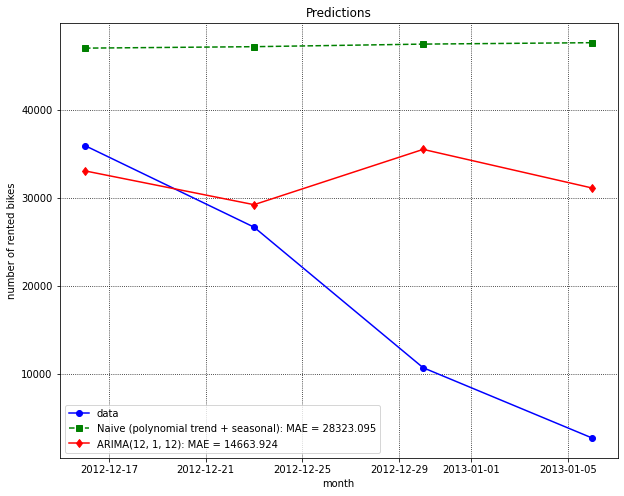

In [ ]:
plt.plot(test.index, test, '-bo', label="data")
plt.plot(test.index, pred, '--gs',
         label=f"Naive (polynomial trend + seasonal): MAE = {mae_naive:0.3f}")
plt.plot(test.index, prediction_arima_test, '-dr',
         label=f"ARIMA{(p, d, q)}: MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':', color='k')
plt.legend()
plt.xlabel("month")
plt.ylabel("number of rented bikes")
plt.title("Predictions")
plt.show()

### Naive stacking of Naive approach and Arima

The Naive Regression approach better predicts minima, while ARIMA better predicts maxima, what if we use the averaged prediction of these models?

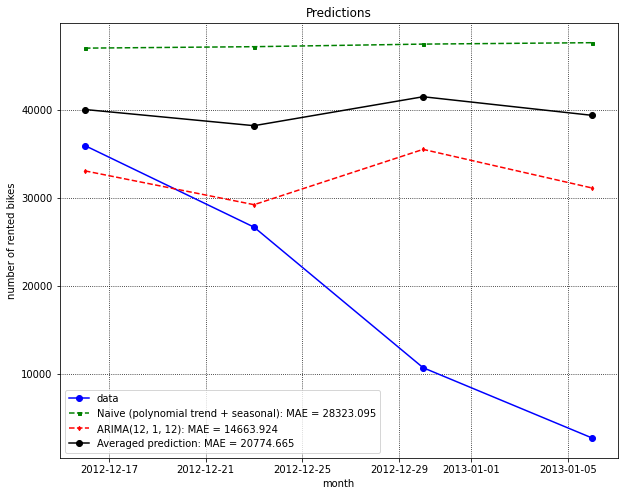

In [ ]:
mae_aver = mean_absolute_error(y_true=test, y_pred=(pred + prediction_arima_test)/2)

plt.plot(test.index, test, '-bo', markersize=6, label="data")
plt.plot(test.index, pred, '--gs',  markersize=3,
         label=f"Naive (polynomial trend + seasonal): MAE = {mae_naive:0.3f}")
plt.plot(test.index, prediction_arima_test, '--dr', markersize=3,
         label=f"ARIMA{(p, d, q)}: MAE = {mae_arima:0.3f}")
plt.plot(test.index, (pred + prediction_arima_test)/2, '-ok',  markersize=6,
         label=f"Averaged prediction: MAE = {mae_aver:0.3f}")
plt.grid(linestyle=':', color='k')
plt.legend()
plt.xlabel("month")
plt.ylabel("number of rented bikes")
plt.title("Predictions")
plt.show()

### Exponential Smoothing (Holt-Winter's)

In [ ]:
holt_winters = ExponentialSmoothing(train, seasonal_periods=2,
                                    trend='add', seasonal='add',
                                    use_boxcox=False,
                                    initialization_method="estimated").fit()
fcast_hw = holt_winters.forecast(len(test))
fcast_hw = pd.Series(fcast_hw)
fcast_hw.index = test.index

mae_hw = mean_absolute_error(y_true=test, y_pred=fcast_hw)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


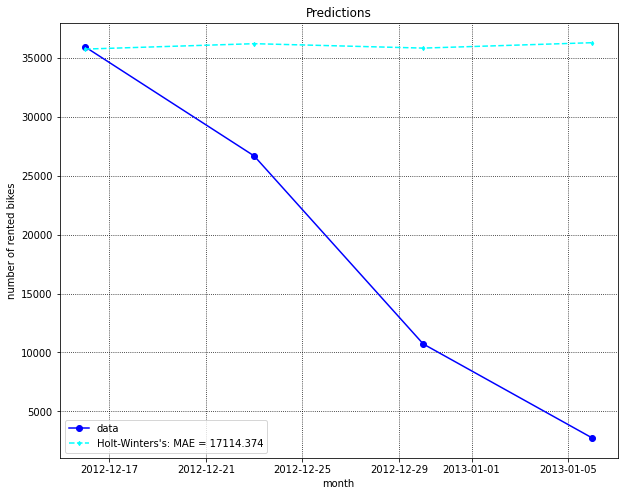

In [ ]:
plt.plot(test.index, test, '-bo', markersize=6, label="data")
plt.plot(test.index, fcast_hw, '--d', color='cyan',
         markersize=3, markerfacecolor='cyan', markeredgecolor='cyan',
         label=f"Holt-Winters's: MAE = {mae_hw:0.3f}")
plt.grid(linestyle=':', color='k')
plt.legend()
plt.xlabel("month")
plt.ylabel("number of rented bikes")
plt.title("Predictions")
plt.show()